What this notebook does:

This notebook processes reviews into sentences based on period separation. The sentences are lemmatized and saved into './ProcessedData/reviewsentences_lemmatized.csv'. This later serves as the input for assigning sentiment to LDA topics for individual sentences ('./LDA_5topic_SentimentAssignment/LDAtopicAssignment_sentences.ipynb')

In [ ]:
#Step one directory up to access the yelp scraping function in the helper_functions module
import os
print(os.getcwd())
os.chdir('../')
os.getcwd()

In [9]:
import numpy as np
import pandas as pd

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import spacy
from spacy.lemmatizer import Lemmatizer
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_web_sm
nlp = spacy.load("en_core_web_sm")

from tqdm import tqdm_notebook as tqdm
from pprint import pprint

import re

In [10]:
reviews = pd.read_csv('./ProcessedData/lemmatizedreviews.csv')
shops = pd.read_csv('./ProcessedData/coffeeshops_withcfcutoff.csv')
#don't forget to add length of review as a feature
reviews['len'] = [len(wordlist) for wordlist in reviews.mreviewtxt.str.split().to_list()]
print(reviews.mreviewtxt[15])
merged = reviews.copy()
merged = merged.merge(shops,how = 'inner',on = 'alias')
merged = merged.head(30)
len(merged)
print(merged.columns)
print(merged.reviewidx.nunique())


it's becoming our go to place for a quick bite or breakfast or coffee or when meeting friends in the neighborhood. i have never seen any kids in there and they don't have high chair or stroller parking. but the baristas are super friendly and always trying to accommodate me when i'm visiting with my daughter. for food and drinks i would give  /  for quality and taste   /  for price.
Index(['reviewidx', 'shopidx', 'alias', 'date', 'revrating', 'reviewtxt',
       'mreviewtxt', 'review_lem_noun', 'review_lem_nounverb',
       'review_lem_nounadj', 'reviewtxt_periodonly', 'review_lem_withperiod',
       'len', 'id', 'name', 'is_closed', 'review_count', 'price', 'rating',
       'transactions', 'latitude', 'longitude', 'geometry', 'index_right',
       'boro_code', 'boro_name', 'county_fip', 'ntacode', 'ntaname',
       'shape_area', 'shape_leng', 'catlist', 'numcoffeemen', 'numreviews',
       'fraccof', 'name_top5count'],
      dtype='object')
30


In [11]:
sentences = [sentence for i in range(len(merged)) for sentence in re.split('[\.]',merged.reviewtxt[i])]
reviewids = [merged.reviewidx[i] for i in range(len(merged)) for sentence in re.split('[\.]',merged.reviewtxt[i])]

In [12]:
sentdf = pd.DataFrame()
sentdf['reviewidx'] = pd.Series(reviewids)
sentdf['sentence'] = pd.Series(sentences)
sentdf.head(20)

,reviewidx,sentence
0,6,It was my first time to the Little Canal
1,6,I was looking for an iced drink and decided ...
2,6,"The interior is small, cozy and intimate"
3,6,The person that help me was not
4,6,He wasn't very friendly or personable
5,6,Ordered an iced oat latte ($6
6,6,00)
7,6,The drink was good (nothing to rave or go ou...
8,6,"If you're looking to catch up with a friend,..."
9,6,


Empty DataFrame
Columns: [reviewidx, sentence]
Index: []


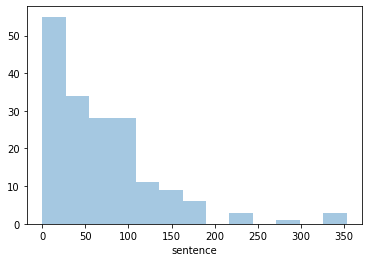

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.distplot(sentdf.sentence.str.len(),kde=False)
sentdf.sentence.str.len().describe()
print(sentdf[sentdf.sentence.str.len()==15])

In [14]:
#Filter out any sentences that are shorter than 15 characters long
#Remove whitespace

sentdf = sentdf[sentdf.sentence.str.len()>15]
sentdf = sentdf[['reviewidx','sentence']]
sentdf.reset_index(inplace=True)
sentdf['sentence'] = sentdf.sentence.str.strip()

print(sentdf.shape)
print(sentdf.head(20))
sentdf.sentence.str.split(' ')

(138, 3)
    index  reviewidx                                           sentence
0       0          6           It was my first time to the Little Canal
1       1          6  I was looking for an iced drink and decided to...
2       2          6           The interior is small, cozy and intimate
3       3          6                    The person that help me was not
4       4          6              He wasn't very friendly or personable
5       5          6                      Ordered an iced oat latte ($6
6       7          6  The drink was good (nothing to rave or go out ...
7       8          6  If you're looking to catch up with a friend, I...
8      10          7  Just moved to the area and although there are ...
9      11          7  Everyone that works there has always been supe...
10     12          7  The cold brew is tasty and buzzy without being...
11     13          7  Lastly and equally important (maybe this is ju...
12     14          7                                   

0      [It, was, my, first, time, to, the, Little, Ca...
1      [I, was, looking, for, an, iced, drink, and, d...
2       [The, interior, is, small,, cozy, and, intimate]
3                [The, person, that, help, me, was, not]
4           [He, wasn't, very, friendly, or, personable]
                             ...                        
133    [I, ordered, the, egg, sandwich, which, was, w...
134                                  [It, was, inedible]
135    [The, egg, however, was, fluffy, and, I, like,...
136    [Good, vibes, here, but, I, probably, won't, b...
137                                  [-@agirlsgottaeatt]
Name: sentence, Length: 138, dtype: object

In [80]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

        
sentences = sentdf.sentence.to_list()
print(sentences[0])
print(len(sentences))
data_words = list(sent_to_words(sentences))

It was my first time to the Little Canal
244523


In [81]:
#Preprocessing the reviews to include bigrams
import gensim
from gensim.utils import simple_preprocess

# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# NLTK Stop words
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')


# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]
def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

#we only focus on nouns and verbs since they probably provide the most distinct topic information
def lemmatization(texts, allowed_postags=['NOUN','PROPN','VERB','ADJ','PUNCT','ADV','AUX','ADP']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc])
    return texts_out

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/thomasyoung/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [82]:
import spacy
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)
# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_lg", disable=['parser', 'ner'])
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams)
print(data_lemmatized[2])

['interior', 'small', 'cozy', 'intimate']


In [83]:
#Create a data frame of the individual sentences of each review
lemrevs = [' '.join(revlist) for revlist in data_lemmatized]
len(lemrevs)

244523

In [84]:
print(sentdf.shape)
sentdf['lemsentence'] = pd.Series(lemrevs)
print(sentdf.tail(10))
sentdf = sentdf[['reviewidx','sentence','lemsentence']]
sentdf.to_csv('./ProcessedData/reviewsentences_lemmatized.csv',index=False)


(244523, 3)
         index  reviewidx                                           sentence  \
244513  307570      52195   Heck, forget restrooms - they don't even have...   
244514  307571      52195   And washing your hands before eating is kind ...   
244515  307574      52195   :(\n\nAnd the most frustrating thing is that ...   
244516  307576      52196                   This location cool, service wise   
244517  307577      52196                                 I still dislike DD   
244518  307578      52196                  That iced coffee tasted like butt   
244519  307580      52197  It's usually not too busy in here when I come ...   
244520  307581      52197   But then again I'm never there during rush ho...   
244521  307582      52197   I enjoy their service the servers are all rel...   
244522  307583      52197   Since it's a new location it looks clean and ...   

                                              lemsentence  
244513   heck forget restroom even way customer